In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel

import json


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

_ = sns.set(style="darkgrid", palette="colorblind")

In [2]:
def get_last_avg_return(entity, project, experiments, window=100, frequency=1000):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)
    dfs = []
    df = pd.DataFrame(columns=["Experiment", "Seed", "Avg. Episodic Return"])
    for run in runs:
        _, experiment, seed, _ = run.name.split("__")
        if experiment in experiments:
            history = run.scan_history(keys=["charts/episodic_return", "global_step"])
            df_ = pd.DataFrame(history)
            df_["Avg. Episodic Return"] = df_["charts/episodic_return"].rolling(window, min_periods=1, center=True, closed="both").mean()
            decimated = np.arange(0, 2990000 + 1, frequency).reshape(-1, 1)
            d = cdist(df_["global_step"].to_numpy().reshape(-1, 1), decimated)
            idx = np.argmin(d, 0)
            df_ = df_.loc[idx]
            df_["Experiment"] = experiment
            df_["seed"] = seed
            df_["Global Step"] = frequency * round(df_["global_step"] / frequency)
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        [
                            {
                                "Experiment": experiment,
                                "Seed": seed,
                                "Avg. Episodic Return": df_["Avg. Episodic Return"].iloc[-1]
                            }
                        ]
                    )
                ]
            )
            dfs.append(df_)
    dfg = df.sort_values(["Experiment","Seed"]).groupby("Experiment")
    means = dfg.mean()["Avg. Episodic Return"].to_numpy()
    pvals = np.zeros((len(experiments), len(experiments)))
    for i, g  in enumerate(experiments):
        for j, h  in enumerate(experiments):
            if i == j:
                pvals[i, j] = means[i]
            else:
                pvals[i, j] = ttest_rel(dfg.get_group(g)["Avg. Episodic Return"], dfg.get_group(h)["Avg. Episodic Return"]).pvalue
    return pvals, pd.concat(dfs, ignore_index=True)

In [3]:
from scipy import integrate

def auc_dict(df, env, result_dict = {}):
    
    grouped_df = df.groupby(['Experiment', 'seed'])

    for (experiment, seed), group in grouped_df:
        x = group['global_step'].tolist()
        y = group['charts/episodic_return'].tolist()
        
        # Calculate the area under the curve for this group
        auc = integrate.trapz(y, x)
        
        # Add the calculated auc to the corresponding Experiment in the result_dict
        if experiment in result_dict:
            if env in result_dict[experiment]:
                result_dict[experiment][env].append(auc)
            else:
                result_dict[experiment].update({env: [auc]})
        else:
            result_dict[experiment] = {env: [auc]}

    return result_dict

In [4]:
entity = "a-jesson"
ppo_projects = {
    "Ant-v4": "ppo-977",
    "Reacher-v4": "ppo-2pj",
    "InvertedDoublePendulum-v4": "ppo-7r5",
    "Pusher-v4": "ppo-804",
    "Humanoid-v4": "ppo-2jo",
    "HumanoidStandup-v4": "ppo-3ox",
    "Swimmer-v4": "ppo-6p6",
    "Hopper-v4": "ppo-624",
    "HalfCheetah-v4": "ppo-f9y",
    "Walker2d-v4": "ppo-5kc",
}
ad = {}
for project, experiment in ppo_projects.items():
    print(project, experiment)
    _, df = pvals, df = get_last_avg_return(
        entity, 
        project, 
        [experiment],
        window=500,
        frequency=8000,
    )
    ad = auc_dict(df, project, ad)

Ant-v4 ppo-977


Reacher-v4 ppo-2pj
InvertedDoublePendulum-v4 ppo-7r5
Pusher-v4 ppo-804
Humanoid-v4 ppo-2jo
HumanoidStandup-v4 ppo-3ox
Swimmer-v4 ppo-6p6
Hopper-v4 ppo-624
HalfCheetah-v4 ppo-f9y
Walker2d-v4 ppo-5kc


		64/32/False		16/128/True		16/128/False		256/8/True		04/512/False		04/512/True		256/8/False		64/32/True		
64/32/False		3123.01		0.00		0.00		0.20		0.02		0.00		0.01		0.20		
16/128/True		0.00		4348.56		0.00		0.00		0.00		0.21		0.08		0.01		
16/128/False		0.00		0.00		1704.46		0.01		0.49		0.00		0.00		0.00		
256/8/True		0.20		0.00		0.01		2705.22		0.21		0.00		0.01		0.11		
04/512/False		0.02		0.00		0.49		0.21		1952.65		0.00		0.00		0.00		
04/512/True		0.00		0.21		0.00		0.00		0.00		4634.25		0.00		0.00		
256/8/False		0.01		0.08		0.00		0.01		0.00		0.00		3890.86		0.18		
64/32/True		0.20		0.01		0.00		0.11		0.00		0.00		0.18		3438.71		


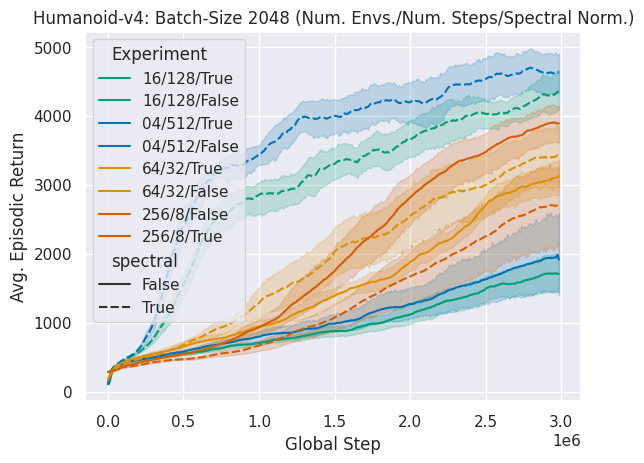

In [46]:
entity = "a-jesson"
project = "Humanoid-v4"
mapping = {
    "vsop-788": "04/512/True",
    "vsop-72n": "04/512/False",
    "vsop-3gu": "16/128/True",
    "vsop-5j4": "16/128/False",
    "vsop-igf": "64/32/True",
    "vsop-2ys": "64/32/False",
    "vsop-6mi": "256/8/True",
    "vsop-802": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=500,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [51]:
ad = auc_dict(df, project, ad)

		64/32/True		16/128/True		04/512/False		64/32/False		16/128/False		256/8/True		256/8/False		04/512/True		
64/32/True		2555.74		0.37		0.84		0.01		0.48		0.00		0.00		0.01		
16/128/True		0.37		2760.73		0.48		0.07		0.27		0.00		0.00		0.05		
04/512/False		0.84		0.48		2491.15		0.04		0.80		0.00		0.01		0.08		
64/32/False		0.01		0.07		0.04		3358.12		0.01		0.00		0.00		0.62		
16/128/False		0.48		0.27		0.80		0.01		2401.83		0.00		0.01		0.01		
256/8/True		0.00		0.00		0.00		0.00		0.00		1032.84		0.81		0.00		
256/8/False		0.00		0.00		0.01		0.00		0.01		0.81		1101.45		0.00		
04/512/True		0.01		0.05		0.08		0.62		0.01		0.00		0.00		3176.28		


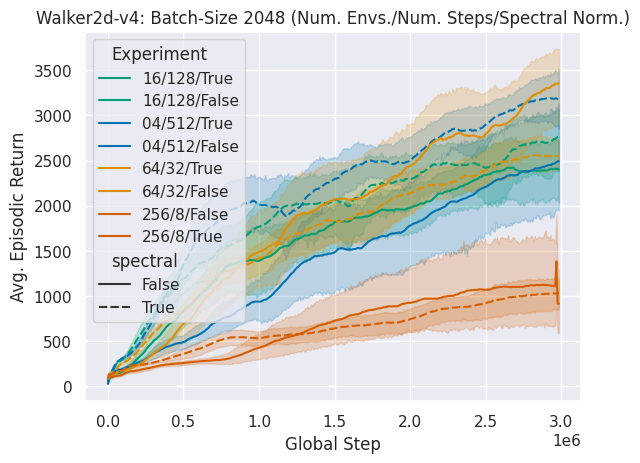

In [36]:
entity = "a-jesson"
project = "Walker2d-v4"
mapping = {
    "vsop-8zb": "04/512/True",
    "vsop-54j": "04/512/False",
    "vsop-2c1": "16/128/True",
    "vsop-5s4": "16/128/False",
    "vsop-1un": "64/32/True",
    "vsop-5dv": "64/32/False",
    "vsop-66b": "256/8/True",
    "vsop-8c9": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=500,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [39]:
ad = auc_dict(df, project, ad)

		16/128/False		64/32/False		04/512/True		256/8/True		64/32/True		256/8/False		04/512/False		16/128/True		
16/128/False		3069.89		0.46		0.24		0.00		0.18		0.04		0.14		0.31		
64/32/False		0.46		3519.41		0.34		0.00		0.00		0.00		0.03		0.76		
04/512/True		0.24		0.34		3973.01		0.00		0.01		0.00		0.02		0.62		
256/8/True		0.00		0.00		0.00		900.04		0.00		0.05		0.00		0.00		
64/32/True		0.18		0.00		0.01		0.00		2300.18		0.23		0.87		0.06		
256/8/False		0.04		0.00		0.00		0.05		0.23		1645.96		0.20		0.00		
04/512/False		0.14		0.03		0.02		0.00		0.87		0.20		2217.73		0.01		
16/128/True		0.31		0.76		0.62		0.00		0.06		0.00		0.01		3707.04		


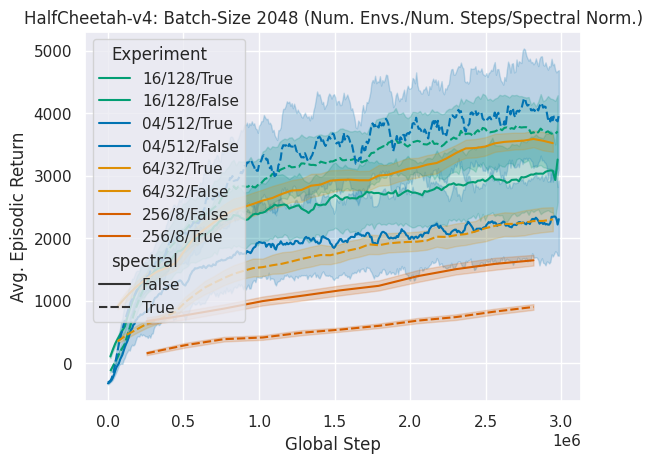

In [54]:
entity = "a-jesson"
project = "HalfCheetah-v4"
mapping = {
    "vsop-56v": "04/512/True",
    "vsop-7sx": "04/512/False",
    "vsop-ut0": "16/128/True",
    "vsop-25d": "16/128/False",
    "vsop-5hh": "64/32/True",
    "vsop-3rm": "64/32/False",
    "vsop-5cx": "256/8/True",
    "vsop-6gi": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=10,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [55]:
ad = auc_dict(df, project, ad)

		16/128/False		04/512/False		256/8/True		64/32/False		16/128/True		64/32/True		256/8/False		04/512/True		
16/128/False		1997.57		0.57		0.11		0.29		0.15		0.88		0.34		0.55		
04/512/False		0.57		1897.93		0.45		0.15		0.40		0.70		0.71		0.45		
256/8/True		0.11		0.45		1788.72		0.00		0.70		0.23		0.68		0.10		
64/32/False		0.29		0.15		0.00		2155.55		0.00		0.28		0.07		0.70		
16/128/True		0.15		0.40		0.70		0.00		1726.44		0.07		0.31		0.07		
64/32/True		0.88		0.70		0.23		0.28		0.07		1977.30		0.39		0.59		
256/8/False		0.34		0.71		0.68		0.07		0.31		0.39		1853.47		0.28		
04/512/True		0.55		0.45		0.10		0.70		0.07		0.59		0.28		2086.36		


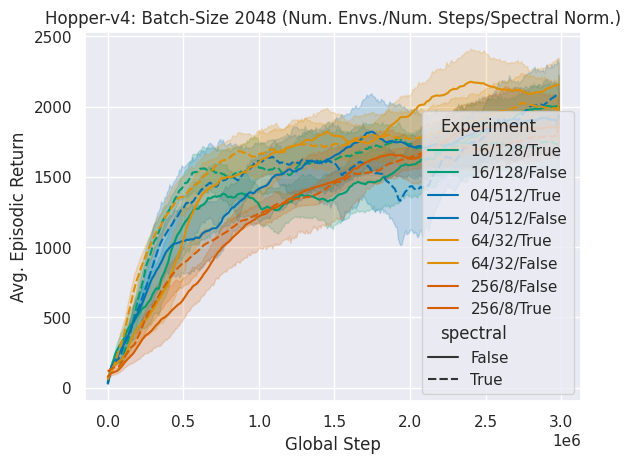

In [57]:
entity = "a-jesson"
project = "Hopper-v4"
mapping = {
    "vsop-anr": "04/512/True",
    "vsop-2kq": "04/512/False",
    "vsop-687": "16/128/True",
    "vsop-12j": "16/128/False",
    "vsop-7ub": "64/32/True",
    "vsop-64i": "64/32/False",
    "vsop-5tb": "256/8/True",
    "vsop-8r6": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=500,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [58]:
ad = auc_dict(df, project, ad)

		256/8/False		04/512/False		256/8/True		64/32/False		16/128/False		64/32/True		04/512/True		16/128/True		
256/8/False		-101.53		0.04		0.57		0.02		0.00		0.00		0.00		0.00		
04/512/False		0.04		-83.39		0.01		0.98		0.09		0.01		0.00		0.00		
256/8/True		0.57		0.01		-103.57		0.01		0.00		0.00		0.00		0.00		
64/32/False		0.02		0.98		0.01		-83.51		0.21		0.01		0.01		0.00		
16/128/False		0.00		0.09		0.00		0.21		-73.50		0.16		0.00		0.02		
64/32/True		0.00		0.01		0.00		0.01		0.16		-61.52		0.97		0.90		
04/512/True		0.00		0.00		0.00		0.01		0.00		0.97		-61.21		0.92		
16/128/True		0.00		0.00		0.00		0.00		0.02		0.90		0.92		-60.80		


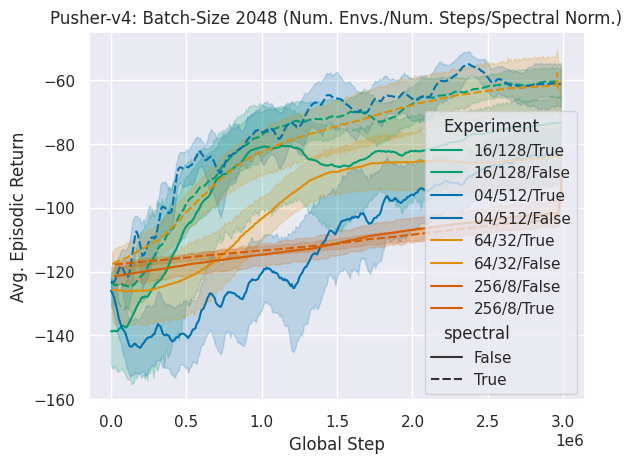

In [59]:
entity = "a-jesson"
project = "Pusher-v4"
mapping = {
    "vsop-7zj": "04/512/True",
    "vsop-1hi": "04/512/False",
    "vsop-8z9": "16/128/True",
    "vsop-45s": "16/128/False",
    "vsop-5gi": "64/32/True",
    "vsop-2tq": "64/32/False",
    "vsop-2gl": "256/8/True",
    "vsop-15e": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=100,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [60]:
ad = auc_dict(df, project, ad)

		04/512/False		64/32/False		256/8/False		256/8/True		64/32/True		04/512/True		16/128/True		16/128/False		
04/512/False		802.89		0.00		0.29		0.03		0.00		0.00		0.00		0.00		
64/32/False		0.00		2158.80		0.00		0.00		0.10		0.00		0.00		0.43		
256/8/False		0.29		0.00		644.89		0.00		0.00		0.00		0.00		0.00		
256/8/True		0.03		0.00		0.00		1186.43		0.00		0.00		0.00		0.00		
64/32/True		0.00		0.10		0.00		0.00		2637.35		0.00		0.00		0.26		
04/512/True		0.00		0.00		0.00		0.00		0.00		3799.20		0.87		0.00		
16/128/True		0.00		0.00		0.00		0.00		0.00		0.87		3845.36		0.00		
16/128/False		0.00		0.43		0.00		0.00		0.26		0.00		0.00		2352.08		


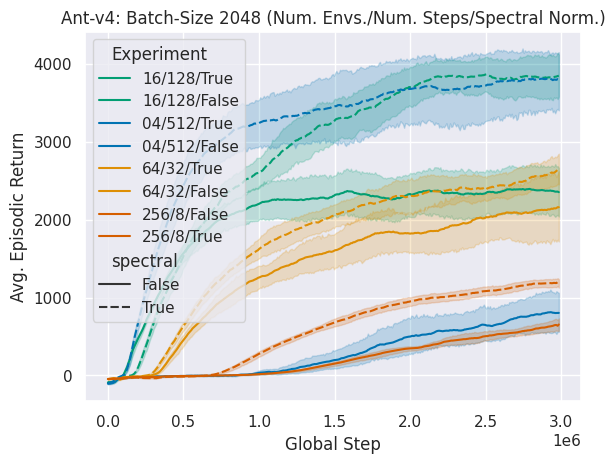

In [61]:
entity = "a-jesson"
project = "Ant-v4"
mapping = {
    "vsop-702": "04/512/True",
    "vsop-1o2": "04/512/False",
    "vsop-7kq": "16/128/True",
    "vsop-7w8": "16/128/False",
    "vsop-62z": "64/32/True",
    "vsop-3jp": "64/32/False",
    "vsop-5g5": "256/8/True",
    "vsop-4ob": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=500,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [62]:
ad = auc_dict(df, project, ad)

		16/128/False		256/8/True		256/8/False		04/512/True		64/32/False		16/128/True		64/32/True		04/512/False		
16/128/False		8008.65		0.01		0.52		0.90		0.24		0.04		0.43		0.66		
256/8/True		0.01		7140.36		0.06		0.13		0.00		0.93		0.00		0.10		
256/8/False		0.52		0.06		7808.35		0.62		0.07		0.20		0.23		0.92		
04/512/True		0.90		0.13		0.62		8083.22		0.65		0.14		0.77		0.76		
64/32/False		0.24		0.00		0.07		0.65		8315.23		0.01		0.80		0.25		
16/128/True		0.04		0.93		0.20		0.14		0.01		7176.25		0.05		0.26		
64/32/True		0.43		0.00		0.23		0.77		0.80		0.05		8258.52		0.36		
04/512/False		0.66		0.10		0.92		0.76		0.25		0.26		0.36		7854.67		


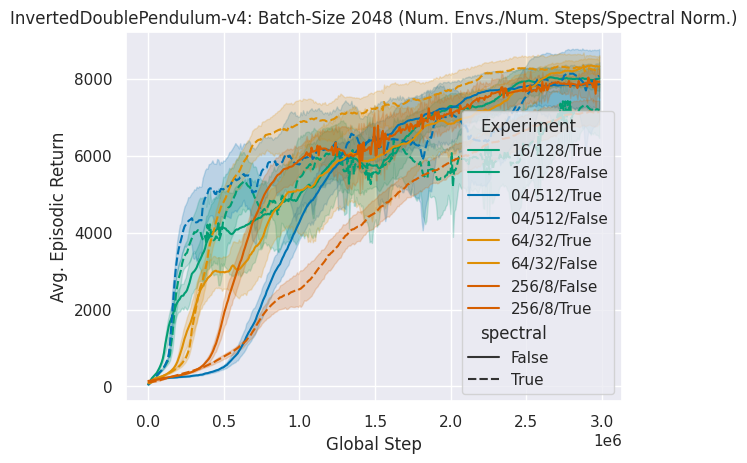

In [63]:
entity = "a-jesson"
project = "InvertedDoublePendulum-v4"
mapping = {
    "vsop-3tf": "04/512/True",
    "vsop-8zd": "04/512/False",
    "vsop-4oj": "16/128/True",
    "vsop-1ix": "16/128/False",
    "vsop-7l1": "64/32/True",
    "vsop-3yr": "64/32/False",
    "vsop-1xa": "256/8/True",
    "vsop-3rv": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=500,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [64]:
ad = auc_dict(df, project, ad)

		64/32/True		256/8/True		64/32/False		16/128/True		16/128/False		256/8/False		04/512/True		04/512/False		
64/32/True		155822.33		0.85		0.92		0.05		0.00		0.21		0.47		0.48		
256/8/True		0.85		154886.05		0.75		0.04		0.02		0.36		0.76		0.27		
64/32/False		0.92		0.75		156161.50		0.02		0.00		0.30		0.53		0.47		
16/128/True		0.05		0.04		0.02		145124.44		0.22		0.01		0.01		0.10		
16/128/False		0.00		0.02		0.00		0.22		138611.66		0.00		0.00		0.01		
256/8/False		0.21		0.36		0.30		0.01		0.00		159114.77		0.10		0.73		
04/512/True		0.47		0.76		0.53		0.01		0.00		0.10		153563.52		0.32		
04/512/False		0.48		0.27		0.47		0.10		0.01		0.73		0.32		161745.86		


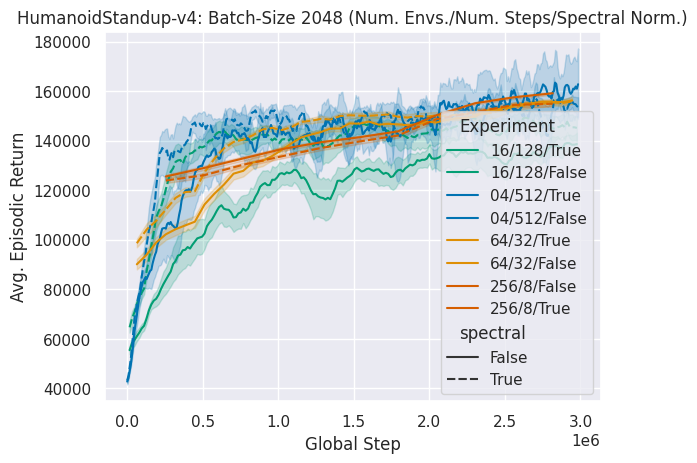

In [65]:
entity = "a-jesson"
project = "HumanoidStandup-v4"
mapping = {
    "vsop-71b": "04/512/True",
    "vsop-91t": "04/512/False",
    "vsop-4le": "16/128/True",
    "vsop-4s4": "16/128/False",
    "vsop-12f": "64/32/True",
    "vsop-1tn": "64/32/False",
    "vsop-1n5": "256/8/True",
    "vsop-648": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=10,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [66]:
ad = auc_dict(df, project, ad)

		04/512/False		256/8/True		04/512/True		64/32/True		16/128/False		16/128/True		256/8/False		64/32/False		
04/512/False		-11.80		0.22		0.00		0.02		0.01		0.01		0.00		0.11		
256/8/True		0.22		-10.50		0.00		0.00		0.00		0.00		0.00		0.00		
04/512/True		0.00		0.00		-15.37		0.01		0.32		0.51		0.00		0.00		
64/32/True		0.02		0.00		0.01		-13.77		0.17		0.03		0.00		0.25		
16/128/False		0.01		0.00		0.32		0.17		-14.71		0.27		0.00		0.02		
16/128/True		0.01		0.00		0.51		0.03		0.27		-15.05		0.00		0.00		
256/8/False		0.00		0.00		0.00		0.00		0.00		0.00		-22.41		0.00		
64/32/False		0.11		0.00		0.00		0.25		0.02		0.00		0.00		-13.21		


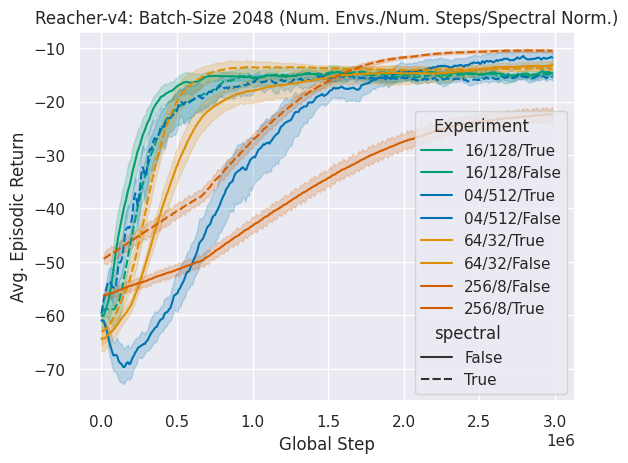

In [67]:
entity = "a-jesson"
project = "Reacher-v4"
mapping = {
    "vsop-3ug": "04/512/True",
    "vsop-1yi": "04/512/False",
    "vsop-7fa": "16/128/True",
    "vsop-77q": "16/128/False",
    "vsop-4s7": "64/32/True",
    "vsop-8be": "64/32/False",
    "vsop-2hy": "256/8/True",
    "vsop-7ia": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=100,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [68]:
ad = auc_dict(df, project, ad)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


		256/8/False		04/512/False		256/8/True		64/32/False		64/32/True		04/512/True		16/128/True		16/128/False		
256/8/False		31.93		0.00		0.02		0.02		0.09		0.00		0.05		0.00		
04/512/False		0.00		90.56		0.00		0.00		0.00		0.00		0.00		0.00		
256/8/True		0.02		0.00		24.87		0.00		0.00		0.00		0.00		0.00		
64/32/False		0.02		0.00		0.00		39.04		0.07		0.00		0.25		0.00		
64/32/True		0.09		0.00		0.00		0.07		36.76		0.00		0.12		0.00		
04/512/True		0.00		0.00		0.00		0.00		0.00		58.44		0.01		0.06		
16/128/True		0.05		0.00		0.00		0.25		0.12		0.01		43.46		0.20		
16/128/False		0.00		0.00		0.00		0.00		0.00		0.06		0.20		48.93		


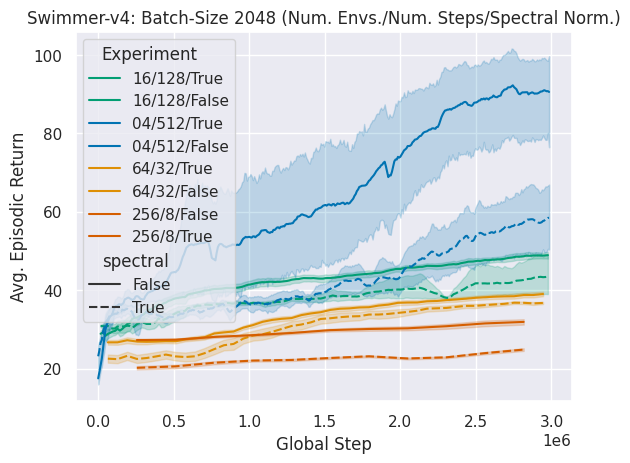

In [69]:
entity = "a-jesson"
project = "Swimmer-v4"
mapping = {
    "vsop-7sl": "04/512/True",
    "vsop-37x": "04/512/False",
    "vsop-8vx": "16/128/True",
    "vsop-90y": "16/128/False",
    "vsop-7j2": "64/32/True",
    "vsop-79w": "64/32/False",
    "vsop-3ao": "256/8/True",
    "vsop-1qv": "256/8/False",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity, 
    project, 
    experiments,
    window=10,
    frequency=8000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in  range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "spectral"] = ("True" in v)
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df, 
    x="Global Step", 
    y="Avg. Episodic Return", 
    hue="Experiment", 
    style="spectral",
    palette=["C2", "C2", "C0", "C0", "C1", "C1", "C3", "C3",],
    dashes=True,
    errorbar=('ci', 95),
)
_ = plt.title(f"{project}: Batch-Size 2048 (Num. Envs./Num. Steps/Spectral Norm.)")

In [70]:
ad = auc_dict(df, project, ad)

In [ ]:
with open("mujoco_efficiency.json", "w") as outfile:
    json.dump(ad, outfile)